# Tâche 3 - Classification automatique de descriptions d'incidents

Cette tâche vise à classifier de courts textes décrivant des incidents qui se sont produits sur des chantiers de construction. Pour chaque incident, on retrouve une étiquette qui correspond au type d’incident (0 à 8). 

Les objectifs de cette tâche sont: 
- de se familiariser avec la classification de texte
- d'apprendre à utiliser les fonctions de base de scikit-learn
- de comprendre comment représenter un texte sous la forme d'un sac de mots (*bag of words*)
- de faire l'évaluation d'un modèle de classification avec un corpus de test
- de tenter d'interpréter les résultats d'un modèle à l'aide des poids d'attributs. 

Pour la première partie, vous devez construire une fonction (*train_and_test_classifier*) qui entraîne un modèle (les options étant la régression logistique et le naïf bayésien) et en faire l'évaluation sur des données d'entraînement et des données de test. Vous devez également évaluer l'impact de la lemmatisation de mots sur la performance des classificateurs. Deux fichiers de textes sont disponibles pour mener votre expérimentation (voir Section 1). 

Pour la deuxième partie, tentez de déterminer à quoi correspond chacune des classes d’incident. Faites une analyse des poids des modèles pour proposer des étiquettes pour chacune des classes. Vous pouvez vous inspirer des notebooks disponibles sur le site du cours. Expliquez clairement comment vous êtes arrivé à vos conclusions. L’important ici est de dégager le thème principal à partir de vos observations et non pas de trouver la formulation exacte des étiquettes. Veuillez noter que certaines classes sont (très) difficiles à identifier. 

Merci de respecter les signatures des fonctions *train_and_test_classifier* et *load_incident_dataset*.

Note sur la lemmatisation: Cette normalisation de texte nécessite l'utilisation d'un modèle qui repose sur l'apprentissage automatique. En conséquence, son temps d'exécution est plus long que le stemming. Si jamais cela ralentit trop vos expérimentations, il est possible de ne faire le traitement qu'une seule fois en sauvegardant les résultats après la première lemmatisation d'un fichier. Cela n'est toutefois pas exigé pour la remise de votre travail et ne sera pas évalué. 

## Section 1 - Lecture des fichiers de données

Voici les fichiers mis à votre disposition pour mener vos expérimentations. La fonction *load_incident_data* peut être utilisée pour lire les 2 fichiers (train et test). Rien à modifier dans cette section. 

In [17]:
import json

train_json_fn = "./data/t3_train.json"
test_json_fn = "./data/t3_test.json"


def load_incident_dataset(filename):
    with open(filename, 'r') as fp:
        incident_list = json.load(fp)
    return incident_list

In [18]:
train_list = load_incident_dataset(train_json_fn)
print("Nombre d'incidents:", len(train_list))
print("\nUn exemple:\n", train_list[10])

Nombre d'incidents: 2475

Un exemple:
 {'text': " At approximately 12:15 p.m. on February 8  2011  Employee # 1 and four other  coworkers were working in the West storage Facility at Enterprise Products  located at Mont Belvieu  Texas. A major fire began but Employee # 1 wasn't  able to escape. The recovery effort was delayed until the evening of February  10  2011  due to the presence of hydrocarbon vapors and small residual fires.   ", 'label': '6'}


In [19]:
test_list = load_incident_dataset(test_json_fn)
print("Nombre d'incidents", len(test_list))
incident = test_list[10]
print("\nUne description d'incident:", incident["text"])
print("\nSon étiquette:", incident["label"])

Nombre d'incidents 1062

Une description d'incident:  At approximately 2:00 p.m. on March 3  2005  Employee #1  an iron worker  was  performing connecting work at a height of approximately 14 ft above grade.  Employee #1 lost his balance and fell to the ground  landing on his feet. In  order to absorb the impact on his legs from the fall  Employee #1 bent down   striking his head on the spud wrench in the tool belt. He sustained 3 stitches  to his forehead  but he was not hospitalized.                                   

Son étiquette: 5


## Section 2 - Entraînement et évaluation des modèles  

Vous pouvez ajouter tout le code dont vous avez besoin pour l'entraînement. Merci de ne pas modifier la signature de la fonction d'entraînement et de bien expliquer votre démarche et vos résultats. N'oubliez pas de faire une recommandation de modèle. Vous pouvez ajouter des cellules au notebook si nécessaire. 

In [20]:
# Import spaCy
import spacy

# Create the English nlp object
nlp = spacy.load("en_core_web_sm")

def normalize_texts(texts, normalization):
    """
    :param texts: une liste de textes à normaliser
    :param normalization: la normalisation à appliquer ('words' ou 'lemma')
    :return: une liste de textes normalisés
    """
    normalized_texts = []
    for text in texts:
        if normalization == 'lemma':
            doc = nlp(text)
            normalized_text = ' '.join([token.lemma_ for token in doc])
        else:
            raise ValueError("Invalid normalization type. Allowed values are 'words' and 'lemma'.")
        normalized_texts.append(normalized_text)
    return normalized_texts

In [21]:
# Importer ici les librairies dont vous avez besoin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB




def train_and_test_classifier(train_fn, test_fn, model='NB', normalization='words'):
    """
    :param train_fn et test_fn: les 2 fichiers utilisées pour entraîner et tester les classificateurs.
    :param model: le type de classificateur. NB = Naive Bayes, LR = Régression logistique.
    :param normalization: la nomralisation appliquée aux mots des descriptions
                 - 'word': les mots des textes sans normalization.
                 - 'lemma': les lemmes des mots obtenus par lemmatisation avec Spacy.
    :return: un dictionnaire contenant 3 valeurs:
                 - l'accuracy à l'entraînement (validation croisée)
                 - l'accuracy sur le jeu de test
                 - la matrice de confusion calculée par scikit-learn sur les données de test
    """

    # Charger les données d'entraînement et de test
    train_list = load_incident_dataset(train_fn)
    test_list = load_incident_dataset(test_fn)

    # Extraire les textes et les étiquettes des données d'entraînement et de test
    train_texts = [incident['text'] for incident in train_list]
    train_labels = [incident['label'] for incident in train_list]

    # Normalisation des mots des textes
    if normalization == 'lemma':
        train_texts = normalize_texts(train_texts, normalization)
 
    # Créer un objet CountVectorizer
    vectorizer = CountVectorizer(lowercase=True)

    # Préparation des données d'entraînement
    X_train = vectorizer.fit_transform(train_texts)
    y_train = train_labels

    # Creation du classificateur
    if model == 'NB':
        classifier = MultinomialNB()
    elif model == 'LR':
        classifier = LogisticRegression(max_iter=5000)
    else:
        print("Le modèle n'est pas reconnu")
        return None

    # Entraînement du classificateur
    classifier.fit(X_train, y_train)

    # Préparation des données de test
    test_texts = [incident['text'] for incident in test_list]
    test_labels = [incident['label'] for incident in test_list]
    X_test = vectorizer.transform(test_texts)

    # Prédiction des étiquettes sur les données de test
    predicted_labels = classifier.predict(X_test)

    # Calcul de l'accuracy sur les données de test
    accuracy_test = classifier.score(X_test, test_labels)
    accuracy_train = cross_val_score(classifier, X_train, train_labels, cv=5, scoring='accuracy').mean()
    confusion_matrix_result = confusion_matrix(test_labels, predicted_labels)

    macro_recall = recall_score(test_labels, predicted_labels, average='macro')
    macro_precision = precision_score(test_labels, predicted_labels, average='macro')
    micro_rappel = recall_score(test_labels, predicted_labels, average='micro')
    micro_precision = precision_score(test_labels, predicted_labels, average='micro')

    # Les résultats à retourner
    results = dict()
    results['classifier'] = classifier
    results['vectorizer'] = vectorizer
    results['macro_recall'] = macro_recall
    results['macro_precision'] = macro_precision
    results['micro_rappel'] = micro_rappel
    results['micro_precision'] = micro_precision
    results['accuracy_train'] = accuracy_train
    results['accuracy_test'] = accuracy_test
    results['confusion_matrix'] = confusion_matrix_result  # la matrice de confusion obtenue de Scikit-learn
    return results

In [22]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns


def display_confusion_matrix(confusion_matrix, classes):
    print("\n\nMatrice de confusion")
    df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax)
    plt.ylabel('Vrai étiquette ')
    plt.xlabel('Étiquette prédite')

### Naive Bayes (with and without lemmatization)

/Users/therryondo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on train set: 0.6937373737373738
Accuracy on test set: 0.6930320150659134


Matrice de confusion


/Users/therryondo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on train set: 0.6921212121212121
Accuracy on test set: 0.7090395480225988


Matrice de confusion


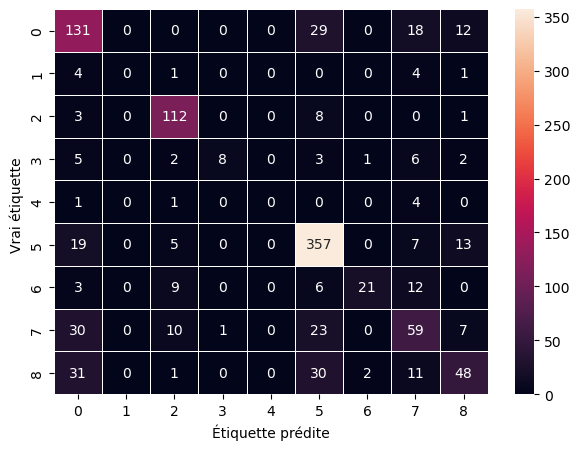

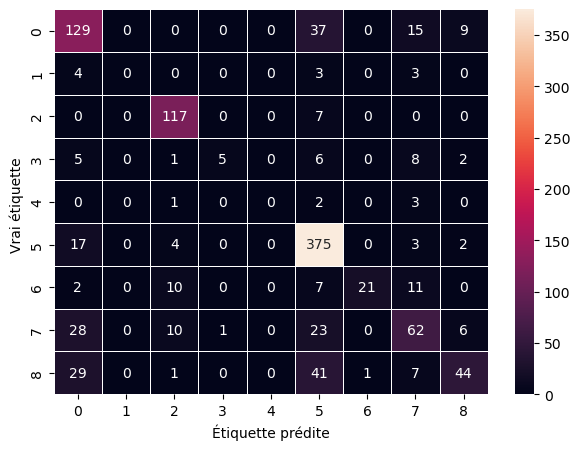

In [65]:
classes = [i for i in range(9)]

result_nb_lemma = train_and_test_classifier(train_json_fn, test_json_fn, model='NB', normalization='lemma')
print(f"Accuracy on train set: {result_nb_lemma['accuracy_train']}")
print(f"Accuracy on test set: {result_nb_lemma['accuracy_test']}")
display_confusion_matrix(result_nb_lemma["confusion_matrix"], classes)

result_nb = train_and_test_classifier(train_json_fn, test_json_fn, model='NB', normalization='words')
print(f"Accuracy on train set: {result_nb['accuracy_train']}")
print(f"Accuracy on test set: {result_nb['accuracy_test']}")
display_confusion_matrix(result_nb["confusion_matrix"], classes)

### Logistic regression (with and without lemma)

/Users/therryondo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on train set: 0.6937373737373738
Accuracy on test set: 0.6930320150659134


Matrice de confusion


/Users/therryondo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on train set: 0.6921212121212121
Accuracy on test set: 0.7090395480225988


Matrice de confusion


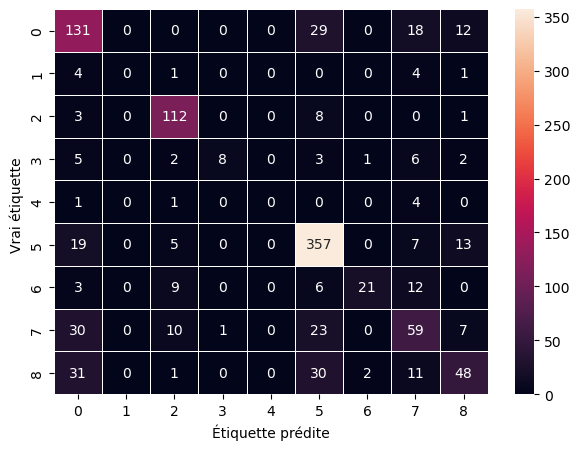

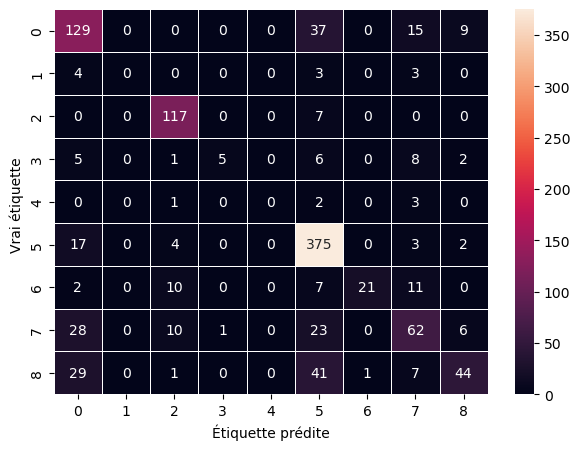

In [64]:
classes = [i for i in range(9)]

result_lr_lemma = train_and_test_classifier(train_json_fn, test_json_fn, model='NB', normalization='lemma')
print(f"Accuracy on train set: {result_lr_lemma['accuracy_train']}")
print(f"Accuracy on test set: {result_lr_lemma['accuracy_test']}")
display_confusion_matrix(result_lr_lemma["confusion_matrix"], classes)

result_lr = train_and_test_classifier(train_json_fn, test_json_fn, model='NB', normalization='words')
print(f"Accuracy on train set: {result_lr['accuracy_train']}")
print(f"Accuracy on test set: {result_lr['accuracy_test']}")
display_confusion_matrix(result_lr["confusion_matrix"], classes)

### Représentation graohique

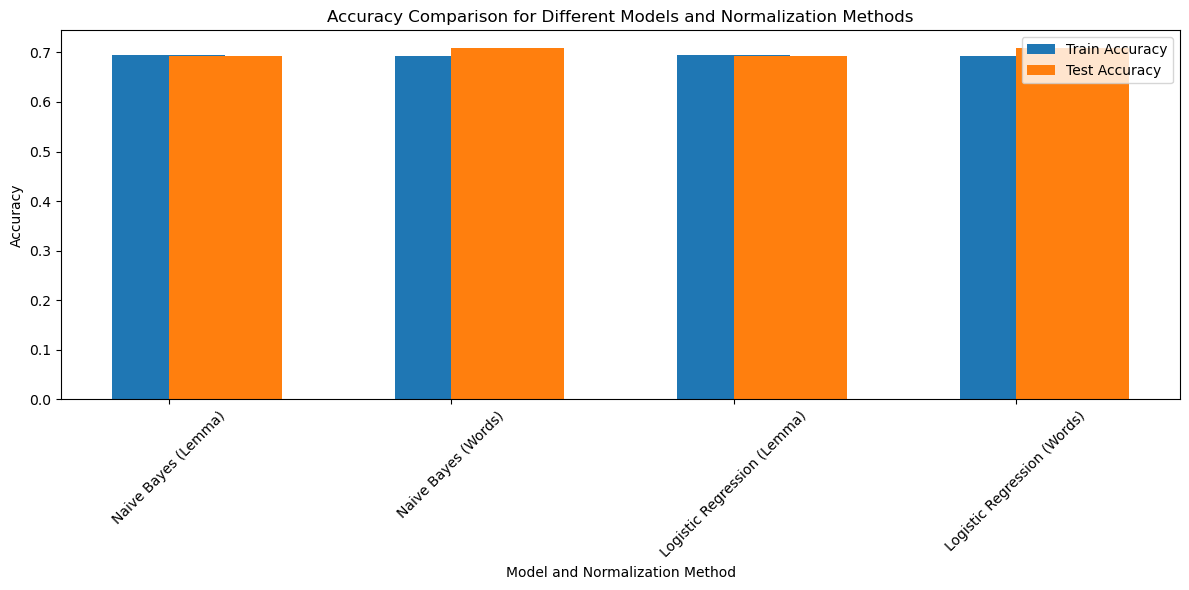

In [66]:
import matplotlib.pyplot as plt

# Define the model types and normalization methods
models = ['Naive Bayes (Lemma)', 'Naive Bayes (Words)', 'Logistic Regression (Lemma)', 'Logistic Regression (Words)']

# Define lists to store accuracy values for each model and train/test sets
train_accuracies = []
test_accuracies = []

# Append accuracy values to the respective lists
train_accuracies.append(result_nb_lemma['accuracy_train'])
test_accuracies.append(result_nb_lemma['accuracy_test'])

train_accuracies.append(result_nb['accuracy_train'])
test_accuracies.append(result_nb['accuracy_test'])

train_accuracies.append(result_lr_lemma['accuracy_train'])
test_accuracies.append(result_lr_lemma['accuracy_test'])

train_accuracies.append(result_lr['accuracy_train'])
test_accuracies.append(result_lr['accuracy_test'])

# Create a bar chart to compare accuracy values
plt.figure(figsize=(12, 6))

# Use a bar chart to compare train and test accuracies for each model
plt.bar(models, train_accuracies, label='Train Accuracy', width=0.4, align='center')
plt.bar(models, test_accuracies, label='Test Accuracy', width=0.4, align='edge')

# Add labels and legend
plt.xlabel('Model and Normalization Method')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.title('Accuracy Comparison for Different Models and Normalization Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Section 3 - À quoi correspondent les classes? Explicabilité du modèle

En utilisant les poids des modèles, tentez d'attribuer une signification aux différentes classes. Comme c'est une épreuve d'analyse de données, il est possible que certaines classes ne soient pas interprétables. Vous n'êtes pas tenu à l'impossible. L'important est d'utiliser ce qu'on observe dans les modèles pour fournir une explication.

Vous pouvez ajouter tout le code et toutes les cellules dont vous avez besoin.

In [24]:
import nltk
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

In [51]:
import pandas as pd
pd.set_option('display.max_rows', None)

# Assuming you have already trained your model and stored the result_nbs in 'result_nb'
classifier = result_nb['classifier']
vectorizer = result_nb['vectorizer']

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to store the words and their feature log probabilities for each class
features_df = pd.DataFrame({'word': feature_names})

# Extract feature log probabilities from the MultinomialNB classifier
feature_log_probs = classifier.feature_log_prob_

# Add columns for each class with their respective feature log probabilities
for i, class_label in enumerate(classifier.classes_):
    features_df[class_label] = feature_log_probs[i]

# Now 'features_df' contains the words and their feature log probabilities for each class

# Create a dictionary to store DataFrames for each class
class_dataframes = {}

# Set a threshold for word selection (e.g., select words with a probability greater than or equal to a certain value)
threshold = -7  # Adjust this threshold as needed

# Loop through each class
for class_label in classifier.classes_:
    # Filter rows where the log probability is greater than or equal to the threshold
    filtered_df = features_df[(features_df[class_label] >= threshold)]
    
    # Create a DataFrame for this class with words and their log probabilities above the threshold
    class_dataframes[class_label] = filtered_df[['word', class_label]].rename(columns={class_label: 'Log Prob'})

# Now 'class_dataframes' contains DataFrames for each class with words and their log probabilities above the threshold

filtered_class_dataframes = {}

# Loop through each class
for class_label, class_df in class_dataframes.items():
    # Filter out words that are in the custom stopWords list
    filtered_df = class_df[~class_df['word'].isin(stops)]
    
    # Add the filtered DataFrame to the new dictionary
    filtered_class_dataframes[class_label] = filtered_df


In [52]:
filtered_class_dataframes['0']
# heavy machinerie accident

,word,Log Prob
34,10,-6.772165
211,2011,-6.698057
213,2013,-6.921200
287,30,-6.683872
641,accident,-6.957568
859,another,-6.819418
902,approximately,-5.308197
921,area,-6.435692
1054,back,-5.949340
1063,backhoe,-6.392675


In [53]:
filtered_class_dataframes['1']
# Drawning

,word,Log Prob
902,approximately,-6.552837
1111,barge,-6.173347
2543,drown,-6.632880
2683,employee,-5.333597
2925,fall,-6.815201
3125,foot,-6.552837
3225,ft,-6.552837
7742,water,-6.284573
7875,work,-6.815201


In [54]:
filtered_class_dataframes['2']
# electical accident

,word,Log Prob
34,10,-6.785450
65,12,-6.835460
287,30,-6.761352
641,accident,-6.648874
807,aluminum,-6.972661
902,approximately,-5.719898
1054,back,-6.972661
1170,begin,-6.861436
1282,boom,-6.371888
1309,box,-6.607202


In [55]:
filtered_class_dataframes['3']
# gaz leak with fire

,word,Log Prob
211,2011,-6.931211
740,air,-6.931211
902,approximately,-6.055743
921,area,-6.806048
1170,begin,-6.806048
1309,box,-6.806048
1391,building,-6.694823
1471,call,-6.931211
1509,carbon,-6.694823
1944,construction,-6.866673


In [57]:
filtered_class_dataframes['4']
# employee burned by hot water

,word,Log Prob
0,00,-6.723432
902,approximately,-6.569281
1413,burn,-6.905753
2206,day,-6.723432
2270,degree,-6.263899
2683,employee,-4.945658
2915,fahrenheit,-6.905753
3532,heat,-6.317967
3641,hospital,-6.375125
3646,hot,-6.905753


In [59]:
filtered_class_dataframes['5']
# Heigh fall from building construction

,word,Log Prob
0,00,-6.727414
34,10,-6.286103
53,11,-6.772198
65,12,-6.359128
97,15,-6.764593
195,20,-6.565991
207,2007,-6.974566
211,2011,-6.902463
212,2012,-6.636760
213,2013,-6.281419


In [60]:
filtered_class_dataframes['6']
# Fire and explosion incident

,word,Log Prob
34,10,-6.919289
902,approximately,-5.963777
914,arc,-6.582816
921,area,-6.582816
929,arm,-6.779527
1271,body,-6.736967
1332,breaker,-6.970582
1413,burn,-5.047486
1578,cause,-6.331502
1605,center,-6.736967


In [61]:
filtered_class_dataframes['7']
# Container explosion

,word,Log Prob
0,00,-6.607173
34,10,-6.390502
212,2012,-6.514800
213,2013,-6.559920
287,30,-6.575424
641,accident,-6.514800
902,approximately,-5.318207
921,area,-6.905666
1017,august,-6.973107
1054,back,-6.099579


In [62]:
filtered_class_dataframes['8']
# Percuted by something

,word,Log Prob
34,10,-6.515817
213,2013,-6.764713
287,30,-6.532911
641,accident,-6.701534
902,approximately,-5.295037
999,attach,-6.681331
1054,back,-6.275866
1145,beam,-5.857156
1248,block,-6.982436
1282,boom,-6.330674


## Section 4 - Section réservée pour nos tests (ne pas modifier)